In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../../..')

In [12]:
import torch
import numpy as np

from magrec.prop.Propagator import MagnetizationPropagator2d
from magrec.prop.Fourier import FourierTransform2d
from magrec.prop.Kernel import HarmonicFunctionComponentsKernel
from magrec.misc.plot import plot_n_components
from magrec import __datapath__

## 2.1. Check `MagneticPropagator2d`

Below we import a dataset with a sample magnetization to check that `MagnetizationPropagator2d(magnetization)` gives a correct magnetic field.

In [6]:
from magrec.misc.load import load_matlab_simulation

In [8]:
datapath = __datapath__ / "SimulatedData/Flakes.json"
data = load_matlab_simulation(datapath=datapath)

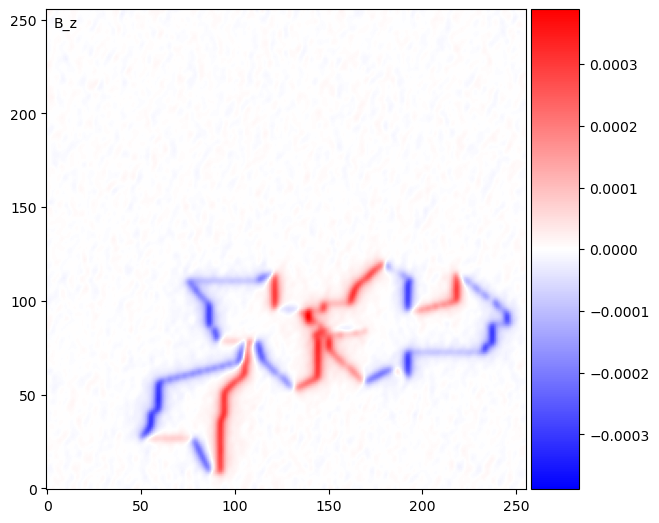

In [9]:
plot_n_components(data["B"]["data"], symmetric=True, labels=[r"B_z"], cmap="bwr")   

## 2.2. Check `HarmonicFunctionComponentsKernel`

This kernel should give three components of the magnetic field from the one data field that we have above.

In [13]:
ft = FourierTransform2d(data["B"]["data"].shape, data["dx"], data["dy"])

In [18]:
kernel = HarmonicFunctionComponentsKernel.define_kernel_matrix(ft.kx_vector, ft.ky_vector, theta=0., phi=0.)

In [26]:
B_NV = torch.tensor(data["B"]["data"])
b_NV = ft.forward(B_NV, dim=(-2, -1))
b = torch.einsum("cjk,jk->cjk", kernel, b_NV)
B = ft.backward(b, dim=(-2, -1))
B.shape # (3, n_x, n_y) <- this should give real vector field map

torch.Size([3, 256, 256])

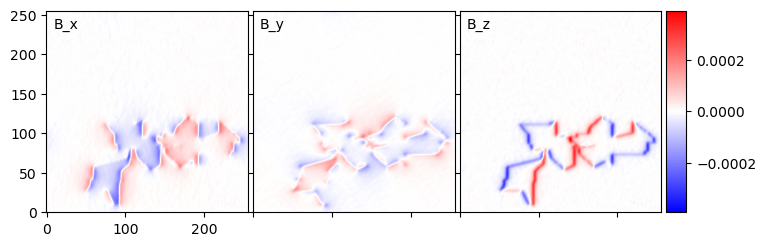

In [27]:
plot_n_components(B, symmetric=True, labels=[r"B_x", r"B_y", r"B_z"], cmap="bwr")

Optimization in this case should be easy and require just one predefined tensor which tracks its gradient. We will create a tensor, called `mag_estimate` and make it `require_grad = true`. Then we will add its values to the optimizer, and run through a `propagator = MagnetizationPropagator2d()`. At each optimizer step, it will directly optimize the values of the `mag_estimate` such that `propagator(mag_estimate) = field_features`. 

In [20]:
wh = (256, 256) # size of the magnetization image
d = 100e-9       # distance between the top of the magnetized surface and the measurement plane
th = 5e-10      # that I don't know yet, thickness of the magnetized layer

propagator = MagnetizationPropagator2d(source_shape=wh, height=d, layer_thickness=th, dx=50e-9, dy=50e-9)

mag_estimate_x = torch.empty(size=wh, requires_grad=True)  # x component of the planar magnetization
mag_estimate_y = torch.empty(size=wh, requires_grad=True)  # y component of the planar magnetization
mag_estimate_z = torch.empty(size=wh, requires_grad=False)  # z component of the planar magnetization, set to zero and not optimizable         


In [25]:
sensor_theta = 0
sensor_phi = 0

SimulatedB = propagator.B_from_M(data["M"]["data"], sensor_theta, sensor_phi)
SimulatedB.shape

torch.Size([3, 3, 256, 256])

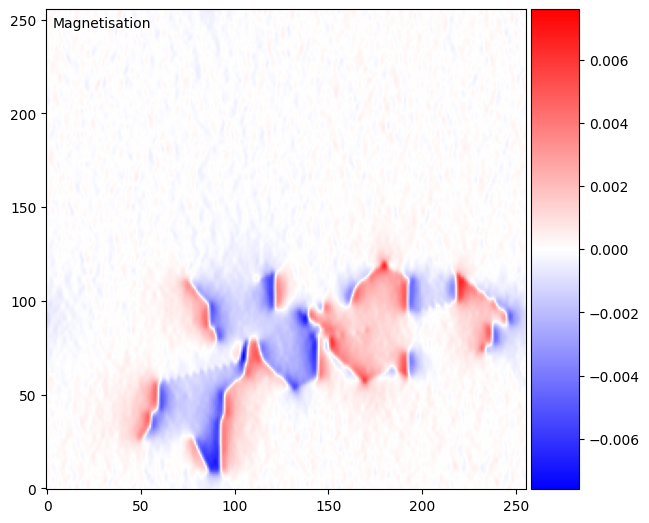

In [34]:
plot_n_components(SimulatedB[0,0,:,:], symmetric=True, labels=[r"Magnetisation"], cmap="bwr")

In [ ]:
import sys
sys.path.append('../..')

In [ ]:
# import torch
# from currec.core.Propagator import MagnetizationPropagator2d

# from currec.plot.plot_field import plot_3components

## 2.1. Check `MagneticPropagator2d`

Below we import a dataset with a sample magnetization to check that `MagnetizationPropagator2d(magnetization)` gives a correct magnetic field.

In [ ]:
wh = (256, 256) # size of the magnetization image
d = 5e-10       # distance between the top of the magnetized surface and the measurement plane
th = 5e-10      # that I don't know yet, thickness of the magnetized layer

propagator = MagnetizationPropagator2d(source_shape=wh, abstand=d, layer_thickness=th)

mag_estimate_x = torch.empty(size=wh, requires_grad=True)  # x component of the planar magnetization
mag_estimate_y = torch.empty(size=wh, requires_grad=True)  # y component of the planar magnetization
mag_estimate_z = torch.empty(size=wh, requires_grad=False)  # z component of the planar magnetization, set to zero and not optimizable         
